In [53]:
import sys
import os
path_to_top_dir = "../"
# Dynamically add the `project` directory to the path
sys.path.append(os.path.abspath(path_to_top_dir))

In [54]:
# Utils
import warnings

# Plotting
from rdkit.Chem.Draw import MolsToGridImage
import matplotlib.pyplot as plt
import seaborn as sns
from pycirclize import Circos

# File management
import json
import numpy as np
import pandas as pd


# GFlowNET
import gflownet
from gflownet.algo.trajectory_balance import TrajectoryBalance
from gflownet.envs.graph_building_env import GraphBuildingEnv
from gflownet.config import init_empty, Config
from scent_gfn.molecule import MoleculeTask

# OpenPOM
from pom_models.functions import fragance_propabilities_from_smiles

# Others
from tensorboard.backend.event_processing import event_accumulator
import torch
from rdkit import Chem

In [55]:
from matplotlib.lines import Line2D

In [56]:

directory = "../results"
vanillasaves=[]
pinesaves=[]
# Iterate over files in directory
for name in os.listdir(directory):
    # Open file
    #print(name)
    if "vanilla" in name:
        vanillasaves.append(name)
    elif "pine" in name:
        pinesaves.append(name)

pinesaves,vanillasaves

(['pine1_2024-12-03__14_19_29', 'pine2_2024-12-08__20_52_30'],
 ['vanilla10_2024-12-07__10_47_14',
  'vanilla11_2024-12-13__20_56_37',
  'vanilla12_2024-12-13__22_27_31',
  'vanilla1_2024-12-03__18_44_11',
  'vanilla2_2024-12-03__20_50_10',
  'vanilla3_2024-12-03__22_12_54',
  'vanilla4_2024-12-04__09_23_46',
  'vanilla5_2024-12-04__15_17_35',
  'vanilla6_2024-12-04__22_30_41',
  'vanilla7_2024-12-05__11_23_44',
  'vanilla8_2024-12-05__22_21_26',
  'vanilla9_2024-12-06__20_41_11'])

In [57]:
vanillalst = ["", "vanilla8","vanilla9", "vanilla10","", "vanilla1", "vanilla2", "vanilla11", "vanilla12", "vanilla3","vanilla4"]  

vanillanames={
    "vanilla1": "OpenPOM, Cosine",
    "vanilla2": "Structure, Cosine",
    "vanilla3": "OpenPOM, Cosine, Exp.pen",
    "vanilla4": "OpenPOM, Cosine, Hard.pen",
    "vanilla5": "",
    "vanilla6": "",
    "vanilla7": "",
    "vanilla8": "OpenPOM, Cosine",
    "vanilla9": "Structure, Cosine",
    "vanilla10": "Structure, Cosine, Beta",
    "vanilla11": "OpenPOM, Tanimoto",
    "vanilla12": "Structure, Tanimoto",
}
pinenames = {
    "pine1": "OpenPOM, Cosine",
    "pine2": "OpenPOM, Cosine, Hard.pen"
}
pinelst= ["", "pine1", "pine2"]  

In [58]:
def find_save(van_str):
    for save in vanillasaves:
        if van_str==save.split("_")[0]:
            return save
    return "not found"
def find_save_pine(van_str):
    for save in pinesaves:
        if van_str==save.split("_")[0]:
            return save
    return "not found"

In [59]:
alst = []
for i in vanillalst:
    if i!="":
        alst.append(find_save(i))
for i in pinelst:
    if i!="":
        alst.append(find_save_pine(i))
alst

['vanilla8_2024-12-05__22_21_26',
 'vanilla9_2024-12-06__20_41_11',
 'vanilla10_2024-12-07__10_47_14',
 'vanilla1_2024-12-03__18_44_11',
 'vanilla2_2024-12-03__20_50_10',
 'vanilla11_2024-12-13__20_56_37',
 'vanilla12_2024-12-13__22_27_31',
 'vanilla3_2024-12-03__22_12_54',
 'vanilla4_2024-12-04__09_23_46',
 'pine1_2024-12-03__14_19_29',
 'pine2_2024-12-08__20_52_30']

In [60]:

directory = "../results"
vanillasaves=[]
pinesaves=[]
# Iterate over files in directory
for name in os.listdir(directory):
    # Open file
    #print(name)
    if "vanilla" in name:
        vanillasaves.append(name)
    elif "pine" in name:
        pinesaves.append(name)

pinesaves,vanillasaves

(['pine1_2024-12-03__14_19_29', 'pine2_2024-12-08__20_52_30'],
 ['vanilla10_2024-12-07__10_47_14',
  'vanilla11_2024-12-13__20_56_37',
  'vanilla12_2024-12-13__22_27_31',
  'vanilla1_2024-12-03__18_44_11',
  'vanilla2_2024-12-03__20_50_10',
  'vanilla3_2024-12-03__22_12_54',
  'vanilla4_2024-12-04__09_23_46',
  'vanilla5_2024-12-04__15_17_35',
  'vanilla6_2024-12-04__22_30_41',
  'vanilla7_2024-12-05__11_23_44',
  'vanilla8_2024-12-05__22_21_26',
  'vanilla9_2024-12-06__20_41_11'])

In [61]:
def calc_porperties(arr):
    return dict(
        arr=arr,
        average = float(np.mean(arr)),
        median = float(np.median(arr)),
        quantile25 = float(np.quantile(arr,0.25)),
        quantile75 = float(np.quantile(arr,0.75)),
        variance = float(np.var(arr, ddof=1)),  # ddof=1 for sample variance
        minimum = float(np.min(arr)),
        maximum = float(np.max(arr))
    )


In [62]:
def save_size(savename,number):
    
    # Model class must be defined somewhere
    state = torch.load(os.path.join(savename, "model_final_save.pt"), weights_only=False)
    #model = statemodel.eval()
    #state["models_state_dict"]

    env_ctx = state["env_ctx"]


    model = gflownet.models.graph_transformer.GraphTransformerGFN(state["env_ctx"],state["cfg"])
    model.load_state_dict(state["models_state_dict"][0])
    model.eval()
    algo = TrajectoryBalance(GraphBuildingEnv(),state["env_ctx"],state["cfg"])
    #task = MoleculeTask(data_tuple=(params["reward_func"], params["similarity"],params["large_mol_pen"], target, params["beta"]))
    trajs = algo.create_training_data_from_own_samples(model, number)
    objs = [env_ctx.graph_to_obj(i['result']) for i in trajs]
    atom_length_lst = []
    smiles_list=[]
    for obj in objs:
        num_of_atoms = obj.GetNumAtoms()
        atom_length_lst.append(num_of_atoms)
        smiles_list.append(Chem.MolToSmiles(obj))

    result_dict= calc_porperties(atom_length_lst)
    result_dict["smiles"]=smiles_list
    return result_dict
    



In [63]:
vanillalst = ["", "vanilla8","vanilla9", "vanilla10","", "vanilla1", "vanilla2", "vanilla11", "vanilla12", "vanilla3","vanilla4"]  

vanillanames={
    "vanilla1": "OpenPOM, Cosine",
    "vanilla2": "Structure, Cosine",
    "vanilla3": "OpenPOM, Cosine, Exp.pen",
    "vanilla4": "OpenPOM, Cosine, Hard.pen",
    "vanilla5": "",
    "vanilla6": "",
    "vanilla7": "",
    "vanilla8": "OpenPOM, Cosine",
    "vanilla9": "Structure, Cosine",
    "vanilla10": "Structure, Cosine, Beta",
    "vanilla11": "OpenPOM, Tanimoto",
    "vanilla12": "Structure, Tanimoto",
}
pinenames = {
    "pine1": "OpenPOM, Cosine",
    "pine2": "OpenPOM, Cosine, Hard.pen"
}
pinelst= ["", "pine1", "pine2"]  

In [64]:
#savename = "c:/Users/paulj/Desktop/prosjekt/pom_cpu-model/results/pine1_2024-12-03__14_19_29"
#save_size(savename,10)

In [65]:
alst = ['vanilla8_2024-12-05__22_21_26',
 'vanilla9_2024-12-06__20_41_11',
 'vanilla10_2024-12-07__10_47_14',
 'vanilla1_2024-12-03__18_44_11',
 'vanilla2_2024-12-03__20_50_10',
 'vanilla11_2024-12-13__20_56_37',
 'vanilla12_2024-12-13__22_27_31',
 'vanilla3_2024-12-03__22_12_54',
 'vanilla4_2024-12-04__09_23_46',
 'pine1_2024-12-03__14_19_29',
 'pine2_2024-12-08__20_52_30']

In [66]:
arr = []
smiles = []
endings = ["v1","v2","v3","v4"]
for ending in endings:
    name = f"vanilla8_2024-12-05__22_21_26{ending}.json"
    with open(f"../images/json/{name}", "r") as file:
        d = json.load(file)
        arr = arr + d["arr"]
        smiles = smiles + d['smiles']
van8 = calc_porperties(arr)
van8["smiles"] = smiles

with open(f"../images/json/vanilla8_2024-12-05__22_21_26.json", "w") as file:
    json.dump(van8,file)

arr = []
smiles = []
endings = ["v1","v2","v3","v4"]
for ending in endings:
    name = f"vanilla9_2024-12-06__20_41_11{ending}.json"
    with open(f"../images/json/{name}", "r") as file:
        d = json.load(file)
        arr = arr + d["arr"]
        smiles = smiles + d['smiles']
van9 = calc_porperties(arr)
van9["smiles"] = smiles

with open(f"../images/json/vanilla9_2024-12-06__20_41_11.json", "w") as file:
    json.dump(van9,file)
 
        

In [67]:
d = {}
for save in alst:
    name = save
    save = f"{save}.json"
    print(save)
    if save[-7:] in ["v1.json","v2.json","v3.json","v4.json"]:
        continue
    with open(f"../images/json/{save}", "r") as file:
        d[name] = json.load(file)
results=d

vanilla8_2024-12-05__22_21_26.json
vanilla9_2024-12-06__20_41_11.json
vanilla10_2024-12-07__10_47_14.json
vanilla1_2024-12-03__18_44_11.json
vanilla2_2024-12-03__20_50_10.json
vanilla11_2024-12-13__20_56_37.json
vanilla12_2024-12-13__22_27_31.json
vanilla3_2024-12-03__22_12_54.json
vanilla4_2024-12-04__09_23_46.json
pine1_2024-12-03__14_19_29.json
pine2_2024-12-08__20_52_30.json


In [68]:
def stack_dfs(df,name, savename):
    df2 = pd.DataFrame(
    columns=[" ","Molecule size"]
    )
    df2[" "]=[name for i in results[savename]["arr"]]
    df2["Molecule size"]=results[savename]["arr"]

    df = pd.concat([df,df2])
    return df

In [69]:
def find_save(van_str):
    for save in vanillasaves:
        if van_str==save.split("_")[0]:
            return save
    return "not found"
def find_save_pine(van_str):
    for save in pinesaves:
        if van_str==save.split("_")[0]:
            return save
    return "not found"

In [70]:
vanillalst

['',
 'vanilla8',
 'vanilla9',
 'vanilla10',
 '',
 'vanilla1',
 'vanilla2',
 'vanilla11',
 'vanilla12',
 'vanilla3',
 'vanilla4']

In [71]:
list(sns.color_palette("Set2"))[0:2]+[(0.0,0.0,0.0)]+list(sns.color_palette("Set2"))[2:]

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.0, 0.0, 0.0),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [72]:
pp = sns.color_palette( list(sns.color_palette("Set2"))[0:2]+[(0.0,0.0,0.0)]+list(sns.color_palette("Set2"))[2:])


vanilla8
vanilla9
vanilla10

vanilla1
vanilla2
vanilla11
vanilla12
vanilla3
vanilla4


C:\Users\paulj\AppData\Local\Temp\ipykernel_5304\4084720645.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Molecule size"], y=df[" "], palette=pp)


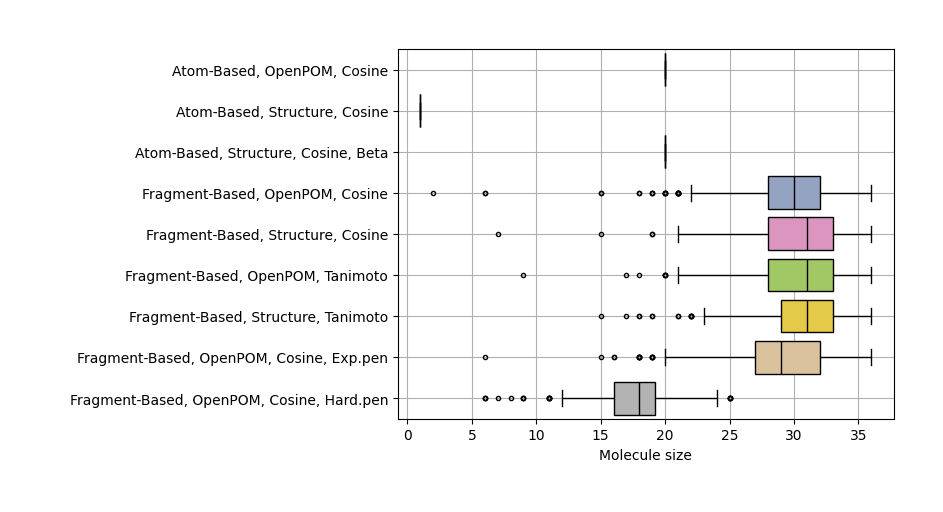

In [73]:

df = pd.DataFrame(
    columns=[" ","Molecule size"]
    )
df2 = pd.DataFrame(
    columns=[" ","Molecule size"]
    )
dflst = [df,df2]
ytickslst=[[],[]]
yticks = []
index=-1
for name in vanillalst:
    print(name)
    
    if name!="":
        savename = find_save(name)
        dflst[index] = stack_dfs(dflst[index], name, savename)
        ytickslst[index].append(vanillanames[name])
    else:
        index+=1
dflst
df=pd.concat(dflst)
sns.boxplot(x=df["Molecule size"], y=df[" "], palette=pp)
y_ticks = plt.yticks()[0]  # Get current y-tick positions
plt.yticks(ticks=y_ticks, labels=['Atom-Based, '+i for i in ytickslst[0]]+['Fragment-Based, '+i for i in ytickslst[1]])

# Manually add subheadings for the ranges
#plt.text(0.1, 0, 'Atom-Based', fontsize=12, color='black', va='center', ha='right', fontweight='bold')
#plt.text(1.9, 2, 'Fragment-Based', fontsize=12, color='black', va='center', ha='right', fontweight='bold')
#plt.axhline(y=1.5, color='gray', linestyle='-', linewidth=1)
plt.grid()
plt.savefig("../images/vanillabox.pdf",bbox_inches="tight")



pine1
pine2


C:\Users\paulj\AppData\Local\Temp\ipykernel_5304\2551454043.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Molecule size"], y=df[" "], palette='Set2')


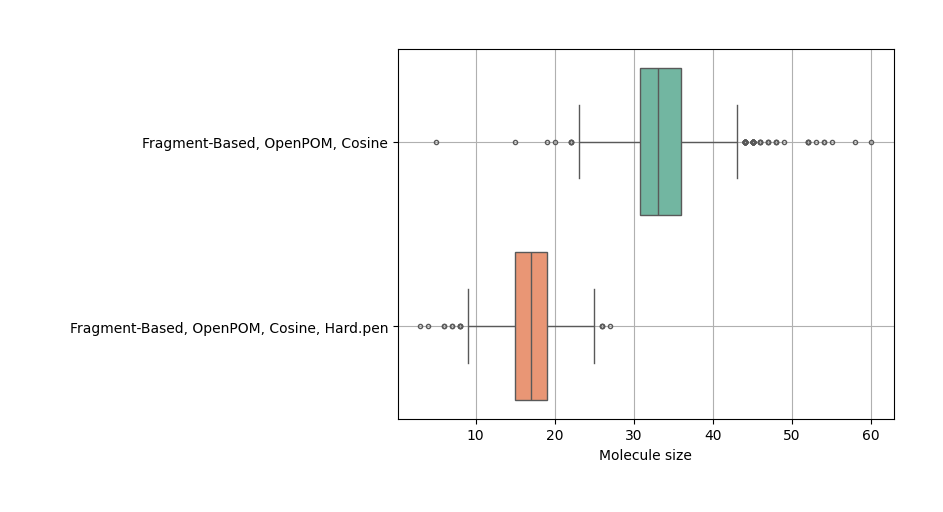

In [35]:
df = pd.DataFrame(
    columns=[" ","Molecule size"]
    )



yticks = []
index=-1
for name in pinelst:
    print(name)
    
    if name!="":
        savename = find_save_pine(name)
        df = stack_dfs(df, name, savename)
        yticks.append(pinenames[name])
    else:
        index+=1
df
sns.boxplot(x=df["Molecule size"], y=df[" "], palette='Set2')
y_ticks = plt.yticks()[0]  # Get current y-tick positions
plt.yticks(ticks=y_ticks, labels=['Fragment-Based, '+i for i in yticks])

# Manually add subheadings for the ranges
#plt.text(0.1, 0, 'Atom-Based', fontsize=12, color='black', va='center', ha='right', fontweight='bold')
#plt.text(1.9, 2, 'Fragment-Based', fontsize=12, color='black', va='center', ha='right', fontweight='bold')
#plt.axhline(y=1.5, color='gray', linestyle='-', linewidth=1)
plt.grid()
plt.savefig("../images/pinebox.pdf",bbox_inches="tight")